In [1]:
# Dirichlet‑Process clustering of NDVI time series
# Piece‑wise (Loredo‑style) temporal model
# PyMC implementation with truncated DP and sequential updating

import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot as plt

import scipy.stats as stats

In [2]:
# ============================================================
# USER PARAMETERS
# ============================================================
MAX_CLUSTERS = 5          # truncation level of DP
N_SEGMENTS   = 23          # piece‑wise bins for temporal model (e.g. 23 for 16‑day NDVI)
ALPHA_DP     = 3.0 #1.0         # DP concentration
SIGMA_MODIS  = 0.02        # NDVI noise (~MODIS typical)

In [3]:
# ============================================================
# UTILITIES
# ============================================================

def doy_to_bin(doy, n_segments=N_SEGMENTS):
    """Map day-of-year to piecewise bin"""
    return np.floor((doy % 365) / 365 * n_segments).astype(int)

In [4]:
def build_model_multi(series_bins, series_values):
    """
    series_bins : list of arrays of bins per series
    series_values: list of NDVI arrays
    """

    n_series = len(series_values)

    with pm.Model() as model:
        # ---------- Stick‑breaking DP ----------
        beta = pm.Beta("beta", 1, ALPHA_DP, shape=MAX_CLUSTERS)
        pi = pm.Deterministic("pi", pm.math.concatenate([beta[0:1], beta[1:] * pt.extra_ops.cumprod(1 - beta[:-1])]))
        pi = pi / pm.math.sum(pi)

        # ---------- Piecewise NDVI per cluster ----------
        a = pm.Uniform("a", lower=0, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))
        # sigma = pm.HalfNormal("sigma", SIGMA_MODIS)

        # ---------- Cluster assignment per SERIES ----------
        z = pm.Categorical("z", p=pi, shape=n_series)

        # ---------- Likelihood per series ----------
        for i in range(n_series):
            mu_i = a[z[i], series_bins[i]]
            # pm.Normal(f"y_{i}", mu=mu_i, sigma=sigma,
            pm.Normal(f"y_{i}", mu=mu_i, sigma=SIGMA_MODIS,
            observed=series_values[i])

    return model


In [5]:
def build_model_multi_hierar(series_bins, series_values):
    """
    series_bins : list of arrays of bins per series
    series_values: list of NDVI arrays
    """

    n_series = len(series_values)

    with pm.Model() as model:
        # ---------- Stick‑breaking DP ----------
        beta = pm.Beta("beta", 1, ALPHA_DP, shape=MAX_CLUSTERS)
        pi = pm.Deterministic("pi", pm.math.concatenate([beta[0:1], beta[1:] * pt.extra_ops.cumprod(1 - beta[:-1])]))
        pi = pi / pm.math.sum(pi)

        # ---------- Piecewise NDVI per cluster ----------
        # version uniforme
        # a = pm.Uniform("a", lower=0, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))

        # version jerárquica
        # mu0 = pm.Normal("mu0", 0.4, 0.2, shape=N_SEGMENTS)
        # tau = pm.HalfNormal("tau", 0.1)

        # version jerárquica autotune
        # global_mean = series_values.mean()
        # global_std  = series_values.std()
        # mu0 = pm.Normal("mu0", global_mean, global_std, shape=N_SEGMENTS)
        # tau = pm.HalfNormal("tau", global_std/2)

        # Hiperprior jerárquico completo
        mu_global = pm.Normal("mu_global", 0.5, 0.5)
        sigma_global = pm.HalfNormal("sigma_global", 0.5)

        mu0 = pm.Normal("mu0", mu_global, sigma_global, shape=N_SEGMENTS)

        tau_scale = pm.HalfNormal("tau_scale", 0.3)
        tau = pm.HalfNormal("tau", tau_scale)

        a = pm.Normal("a", mu0, tau, shape=(MAX_CLUSTERS,N_SEGMENTS))
        # sigma = pm.HalfNormal("sigma", SIGMA_MODIS)

        # ---------- Cluster assignment per SERIES ----------
        z = pm.Categorical("z", p=pi, shape=n_series)

        # ---------- Likelihood per series ----------
        for i in range(n_series):
            mu_i = a[z[i], series_bins[i]]
            # pm.Normal(f"y_{i}", mu=mu_i, sigma=sigma,
            pm.Normal(f"y_{i}", mu=mu_i, sigma=SIGMA_MODIS,
            observed=series_values[i])

    return model


In [6]:
def synthetic_series(n_series, anios, sigma=SIGMA_MODIS):
    """
    Generate NDVI synthetic series in MODIS 16-day composites (~23 per year)
    Clusters:
        0 → bosque perenne
        1 → cultivo anual
        2 → doble cultivo
    """

    n_quincenas = 23
    q = np.arange(n_quincenas*anios)

    series = []
    true_clusters = []

    for i in range(n_series):
        c = np.random.choice([0,1,2])
        true_clusters.append(c)

        if c == 0:   # bosque
            ndvi = 0.4 + 0.15*np.sin(2*np.pi*q/n_quincenas)

        elif c == 1: # cultivo anual
            ndvi = 0.2 + 0.5*((q%n_quincenas>6)&(q%n_quincenas<15))

        else:        # doble cultivo
            ndvi = 0.2 \
                 + 0.35*((q%n_quincenas>3)&(q%n_quincenas<7)) \
                 + 0.35*((q%n_quincenas>12)&(q%n_quincenas<16))

        ndvi = ndvi.astype(float)
        ndvi += np.random.normal(0, sigma, size=len(q))

        # clip NDVI realista
        ndvi = np.clip(ndvi, 0, 0.9)

        series.append(ndvi)

    return q, np.array(series), np.array(true_clusters)



In [7]:
quincenas, series, true_clusters = synthetic_series(n_series=30, anios=3, sigma=SIGMA_MODIS)

Text(0.5, 1.0, 'Series sintéticas con clusters conocidos')

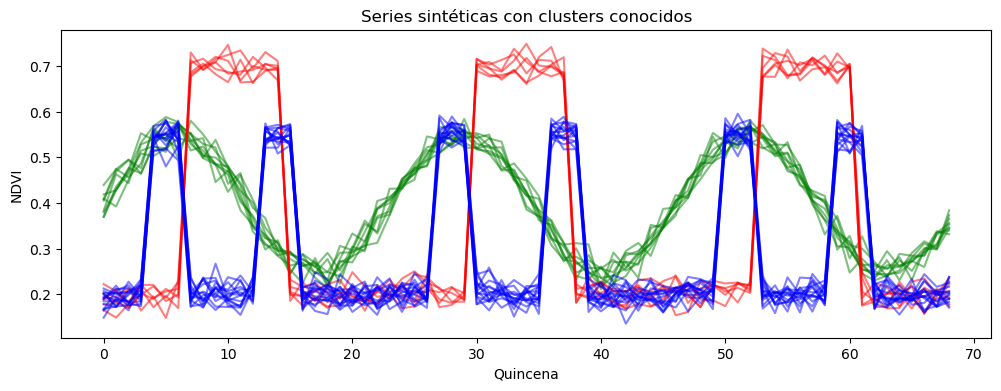

In [8]:
fig = plt.figure(figsize=(12,4))

plt.plot(quincenas, series[true_clusters == 0, :].T, color='green', alpha=0.5)
plt.plot(quincenas, series[true_clusters == 1, :].T, color='red', alpha=0.5)
plt.plot(quincenas, series[true_clusters == 2, :].T, color='blue', alpha=0.5)
plt.xlabel("Quincena")
plt.ylabel("NDVI")
plt.title("Series sintéticas con clusters conocidos")
# plt.plot(true_clusters)

### version avanzada inicializacion de clusters

In [9]:
from scipy.stats import norm

def crp_init(series_values, alpha, max_clusters, sigma, n_segments):
    """
    Inicialización estilo Chinese Restaurant Process
    compatible con DP piece-wise
    """

    n_series = len(series_values)
    order = np.random.permutation(n_series)

    z = -np.ones(n_series, dtype=int)
    clusters = []

    for i in order:
        s = series_values[i]

        probs = []

        # --- clusters existentes ---
        for k, members in enumerate(clusters):
            nk = len(members)

            mean_curve = np.mean([series_values[j] for j in members], axis=0)

            ll = np.sum(norm.logpdf(s, mean_curve, sigma))
            probs.append(np.log(nk) + ll)

        # --- cluster nuevo ---
        ll_new = np.sum(norm.logpdf(s, np.mean(s), sigma))
        probs.append(np.log(alpha) + ll_new)

        probs = np.exp(probs - np.max(probs))
        probs /= probs.sum()

        k_new = np.random.choice(len(probs), p=probs)

        if k_new == len(clusters):
            clusters.append([i])
            z[i] = k_new
        else:
            clusters[k_new].append(i)
            z[i] = k_new

        if len(clusters) >= max_clusters:
            break

    # llenar no asignados
    z[z < 0] = 0
    return z

In [10]:
np.random.seed(0)

z_init = crp_init(
    series_values=series,
    alpha=ALPHA_DP,
    max_clusters=MAX_CLUSTERS,
    sigma=SIGMA_MODIS,
    n_segments=N_SEGMENTS
)

# quincenas, series, true_clusters = synthetic_series(n_series=30, anios=3)
# series_bins = [doy_to_bin(quincenas) for _ in series]
# series_bins = [quincenas for _ in series]
series_bins = [np.arange(len(s)) % 23 for s in series]
# model = build_model_multi(series_bins, series)
model = build_model_multi_hierar(series_bins, series)

# with model:
#     trace = pm.sample(draws=5000, tune=1000, chains=4)
#     z_post = trace.posterior["z"].mean(dim=("chain","draw")).values
#     z_est = np.round(z_post).astype(int)

with model:
    trace = pm.sample(draws=3000, 
                      tune=500, 
                      chains=4, 
                      target_accept=0.9, 
                      initvals=[{"z": z_init} for _ in range(4)])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta, mu_global, sigma_global, mu0, tau_scale, tau, a]
>CategoricalGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 148 seconds.
/home/fran/miniconda3/envs/pyMCJax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 690 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
# model.free_RVs

for rv in model.free_RVs:
    print(rv.name, rv.eval().shape)

beta (5,)
mu_global ()
sigma_global ()
mu0 (23,)
tau_scale ()
tau ()
a (5, 23)
z (30,)


In [12]:
z_samples = trace.posterior["z"].stack(samples=("chain","draw")).values
z_est = stats.mode(z_samples, axis=1, keepdims=False).mode


print("True clusters:")
print(true_clusters)
print("Estimated clusters:")
print(z_est)
print("Estimated N:", len(np.unique(z_est)))

True clusters:
[2 2 2 2 0 2 0 0 0 0 2 2 0 2 1 2 1 1 1 2 1 2 0 0 2 1 2 2 0 2]
Estimated clusters:
[0 0 0 0 3 0 3 3 3 3 0 0 3 0 1 0 1 1 1 0 1 0 3 3 0 1 0 0 3 0]
Estimated N: 3


### Evaluacion convergencia

In [13]:
trace.posterior

<xarray.Dataset> Size: 17MB
Dimensions:       (chain: 4, draw: 3000, mu0_dim_0: 23, a_dim_0: 5,
                   a_dim_1: 23, z_dim_0: 30, beta_dim_0: 5, pi_dim_0: 5)
Coordinates:
  * chain         (chain) int64 32B 0 1 2 3
  * draw          (draw) int64 24kB 0 1 2 3 4 5 ... 2995 2996 2997 2998 2999
  * mu0_dim_0     (mu0_dim_0) int64 184B 0 1 2 3 4 5 6 ... 16 17 18 19 20 21 22
  * a_dim_0       (a_dim_0) int64 40B 0 1 2 3 4
  * a_dim_1       (a_dim_1) int64 184B 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22
  * z_dim_0       (z_dim_0) int64 240B 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
  * beta_dim_0    (beta_dim_0) int64 40B 0 1 2 3 4
  * pi_dim_0      (pi_dim_0) int64 40B 0 1 2 3 4
Data variables:
    mu_global     (chain, draw) float64 96kB 0.3224 0.3538 ... 0.3548 0.344
    mu0           (chain, draw, mu0_dim_0) float64 2MB 0.3213 0.3087 ... 0.2627
    a             (chain, draw, a_dim_0, a_dim_1) float64 11MB 0.1885 ... 0.3566
    z             (chain, draw, z_dim_0) int64 3MB 0 0 0 0 3 0 3 ... 2 1 2 2 4 2
    beta          (chain, draw, beta_dim_0) float64 480kB 0.5033 ... 0.77
    sigma_global  (chain, draw) float64 96kB 0.01677 0.04495 ... 0.05805 0.05802
    tau_scale     (chain, draw) float64 96kB 0.3991 0.6036 ... 0.2871 0.1865
    tau           (chain, draw) float64 96kB 0.1779 0.1704 ... 0.1654 0.2024
    pi            (chain, draw, pi_dim_0) float64 480kB 0.5033 0.02561 ... 0.343
Attributes:
    created_at:                 2026-02-20T20:19:10.312047+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.12.0
    sampling_time:              147.85206866264343
    tuning_steps:               500

In [14]:
import arviz as az
# az.summary(trace, var_names=["z"])
az.summary(trace)

/home/fran/miniconda3/envs/pyMCJax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/fran/miniconda3/envs/pyMCJax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/fran/miniconda3/envs/pyMCJax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/fran/miniconda3/envs/pyMCJax/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/fran/miniconda3/envs/pyMCJax/lib/p

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_global,0.354,0.025,0.307,0.400,0.001,0.000,1494.0,5251.0,1.00
mu0[0],0.333,0.054,0.224,0.429,0.001,0.001,5169.0,6378.0,1.00
mu0[1],0.336,0.053,0.231,0.434,0.001,0.001,5359.0,6651.0,1.00
mu0[2],0.339,0.053,0.231,0.436,0.001,0.001,5716.0,6510.0,1.00
mu0[3],0.343,0.053,0.234,0.439,0.001,0.001,6493.0,6154.0,1.01
...,...,...,...,...,...,...,...,...,...
pi[0],0.274,0.171,0.000,0.505,0.074,0.031,7.0,28.0,1.55
pi[1],0.087,0.079,0.000,0.225,0.033,0.005,6.0,57.0,1.70
pi[2],0.144,0.144,0.000,0.400,0.066,0.023,6.0,30.0,1.90
pi[3],0.108,0.101,0.000,0.276,0.044,0.005,6.0,96.0,1.73


In [15]:
trace.posterior["pi"].mean(dim=("chain","draw")).values

array([0.27407826, 0.0874203 , 0.14398275, 0.10758668, 0.11466073])

### Evaluacion clusters

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def aligned_confusion(true_labels, est_labels):
    true_labels = np.array(true_labels)
    est_labels  = np.array(est_labels)

    cm = confusion_matrix(true_labels, est_labels)

    # Hungarian algorithm → maximizar diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    aligned_cm = cm[:, col_ind]
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}

    aligned_est = np.array([mapping[e] for e in est_labels])

    return aligned_cm, aligned_est, mapping


In [17]:
def plot_confusion(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Estimated cluster")
    plt.ylabel("True cluster")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     fontsize=12)

    plt.tight_layout()
    plt.show()


Cluster mapping: {3: 0, 1: 1, 0: 2, 2: 3}


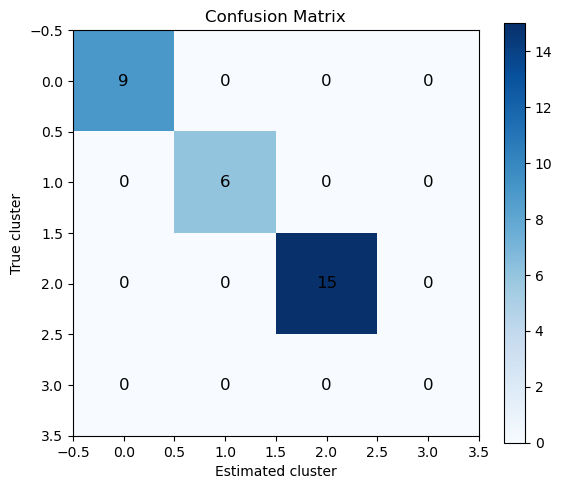

In [18]:
cm, aligned_est, mapping = aligned_confusion(true_clusters, z_est)

print("Cluster mapping:", mapping)
plot_confusion(cm)


Evaluacion series de tiempo

In [27]:
def plot_cluster_ndvi_posterior(trace, quincenas, z_est, ci=0.9):
    """
    trace   : trace de PyMC
    quincenas    : array quincenas
    z_est   : cluster asignado por serie
    """

    a_post = trace.posterior["a"].stack(sample=("chain","draw")).values
    # shape = (Kmax, N_segments, n_samples)

    clusters = np.unique(z_est)
    # bins = np.floor((days % 365) / 365 * n_segments).astype(int)
    bins = quincenas

    plt.figure(figsize=(10,4))
    
    for k in clusters:

        samples = a_post[k, bins, :]  # (365, n_samples)

        mean = samples.mean(axis=1)
        low  = np.percentile(samples, (1-ci)/2*100, axis=1)
        high = np.percentile(samples, (1+(ci))/2*100, axis=1)

        n_series = np.sum(z_est == k)

        plt.plot(quincenas, mean, label=f"Cluster {k} (n={n_series})")
        plt.fill_between(quincenas, low, high, alpha=0.25)

    # series reales
    plt.plot(quincenas[:23], series[true_clusters == 0, :].T[:23], color='green', alpha=0.1)
    plt.plot(quincenas[:23], series[true_clusters == 1, :].T[:23], color='red', alpha=0.1)
    plt.plot(quincenas[:23], series[true_clusters == 2, :].T[:23], color='blue', alpha=0.1)
    plt.xlabel("Quincena")
    plt.ylabel("NDVI")
    plt.title("NDVI promedio por cluster (posterior PyMC)")
    plt.legend()
    plt.grid(True)
    plt.show()


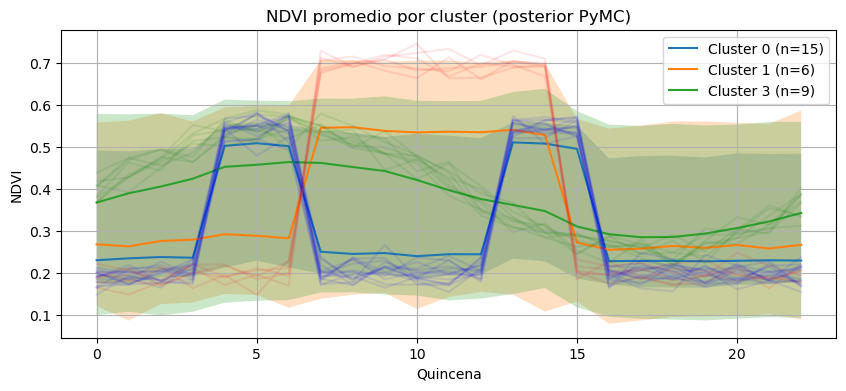

In [28]:
plot_cluster_ndvi_posterior(trace, quincenas[:23], z_est, ci=0.9)